## Retrieve Global Climate Model data

This notebooks shows how to retrieve Global Climate Models (GCMs) data using a THREDSS server maintained by the [Santander Climate Data Service](https://scds.es/en) (University of Cantabria-CSIC). This system provides user-friendly access to a variety of remote climate data sources, allowing the retrieval of specific models, time frames and spatial extents the user is interested in. This is done in  [`climate4R.UDG` R library](https://github.com/SantanderMetGroup/climate4R.UDG) which is part of the [`climate4R` framework](https://github.com/SantanderMetGroup/climate4R).

### Setup and configuration

To start, we load the required libraries:

In [ ]:
rm(list=ls())
library(climate4R.UDG)
library(loadeR) # part of climate4R:  load data
library(transformeR) # part of climate4R:  data manipulation and analysis
library(visualizeR) # part of climate4R: visualization

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

Loading required package: rJava

Loading required package: loadeR.java

Java version 23x amd64 by N/A detected

The maximum JVM heap space available is: 2.00 GB

NetCDF Java Library Version: 4.6.0-SNAPSHOT (Built-On: 20150423.1338) loaded and ready

You can manually set the NetCDF Java Library version before loading the package:
options(loadeR.java_forced_version = "X.Y.Z")
library(loadeR.java)

netCDF-Java CLASSPATH from bundled java package directory: /home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java:/home/ana/micromamba/envs/prosecco/lib/R/library/loadeR.java/java/netcdfAll-4.6.0-SNAPSHOT.jar

loadeR version 1.8.4 (2025-08-07) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.



We set the working directories and define the predictor variables we are insterested in. Note that statistical downscaling requires large-scale predictors at different vertical levels. Here we load the predictors which were selected as best performing ones in the evaluation of the statistical downscaling methods with reanalysis data (ERA5). These variables are:
| Variable | Vertical levels required (hPa) | Short name |
|:---|:-:|---:|
| u component of wind | 500, 700, 850 | "ua@50000", "ua@70000", "ua@85000" |
| v component of wind | 500, 700, 850 | "va@50000", "va@70000", "va@85000" |
| Geopotential| 500, 850 | "zg@50000", "zg@85000" |
| Temperature | 500, 700, 850, 2 meters | "ta@50000", "ta@70000", "ta@85000","2m_temperature" |
| Specific humidity | 500, 850 | "q50000", "q85000" |

Next we define the spatial extent (a bit larger that the reanalysis counterpart to avoid NAs when interpolating) and periods. Regarding the periods, note that historical simulations end in 2005 and scenario simulations cover 2006 to 2100.

In [3]:
lats.big <- c(42,51)
lons.big <- c(3, 17)
years.hist <- seq(1991, 2005)
years.rcp<- seq(2006,2100)

Reanalysis data are required for the spatial interpolation of the GCMs, which are developed on a different grid (and coarser than original ERA5 data). Bear in mind that ERA5 is developed on, approximately, a 25km grid (0.25º) but has been upscaled to a 200km grid (2º) for the sake of comparison with the GCM data. This is a common practice in statistical downscaling, where only large-scale variables (not fine, high resolution configurations) are considered.

In [ ]:
work.dir <- "/home/jovyan/data/"
load(paste0(work.dir,"/ERA5_P8predictors_2deg_1991-2020.Rdata")) # loaded object: x
grid_rea <- getGrid(x)

### Inventory of the available simulations

Here we use `UDG.datasets()` from `climate4R.UDG` package to make an inventory of the available CMIP5 GCMs. Note that inventories are done separately for the historical simulations, RCP4.5 and RCP8.5, since each model may have different simulations available.

In [5]:
cmip.historical <- UDG.datasets("CMIP5-subset.*historical")$CMIP5_subset[-c(4,8)]
cmip.rcp45 <-  UDG.datasets("CMIP5-subset.*rcp45")$CMIP5_subset[-c(4,8)]
cmip.rcp85 <-  UDG.datasets("CMIP5-subset.*rcp85")$CMIP5_subset[-c(4,8)]
scenList <- c("rcp45","rcp85")

# summary table
table <- data.frame(matrix(ncol = 3, nrow = length(cmip.historical)))
colnames(table) <- c("historical", "rcp45", "rcp85")
table$historical <- cmip.historical
table$rcp45 <- cmip.rcp45
table$rcp85 <- cmip.rcp85
table

Matches found for: CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information

Matches found for: CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information

Matches found for: CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information



historical,rcp45,rcp85
<chr>,<chr>,<chr>
CMIP5-subset_CanESM2_r1i1p1_historical,CMIP5-subset_CanESM2_r1i1p1_rcp45,CMIP5-subset_CanESM2_r1i1p1_rcp85
CMIP5-subset_CNRM-CM5_r1i1p1_historical,CMIP5-subset_CNRM-CM5_r1i1p1_rcp45,CMIP5-subset_CNRM-CM5_r1i1p1_rcp85
CMIP5-subset_IPSL-CM5A-MR_r1i1p1_historical,CMIP5-subset_IPSL-CM5A-MR_r1i1p1_rcp45,CMIP5-subset_IPSL-CM5A-MR_r1i1p1_rcp85
CMIP5-subset_GFDL-ESM2M_r1i1p1_historical,CMIP5-subset_GFDL-ESM2M_r1i1p1_rcp45,CMIP5-subset_GFDL-ESM2M_r1i1p1_rcp85
CMIP5-subset_MPI-ESM-MR_r1i1p1_historical,CMIP5-subset_MPI-ESM-MR_r1i1p1_rcp45,CMIP5-subset_MPI-ESM-MR_r1i1p1_rcp85
CMIP5-subset_MPI-ESM-LR_r1i1p1_historical,CMIP5-subset_MPI-ESM-LR_r1i1p1_rcp45,CMIP5-subset_MPI-ESM-LR_r1i1p1_rcp85
CMIP5-subset_EC-EARTH_r12i1p1_historical,CMIP5-subset_EC-EARTH_r12i1p1_rcp45,CMIP5-subset_EC-EARTH_r12i1p1_rcp85
CMIP5-subset_NorESM1-M_r1i1p1_historical,CMIP5-subset_NorESM1-M_r1i1p1_rcp45,CMIP5-subset_NorESM1-M_r1i1p1_rcp85


Or filtering CMIP5 datasets in a full inventory:

In [6]:
df <- read.csv("https://data.meteo.unican.es/inventory.csv")
subset_hist <- subset(df, activity == 'CMIP5'  & experiment == 'historical' & variable %in% c("ua", "va", "zg", "ta", "hus", "tas"))
# make a table with the number of datasets available for each model and variables of interest:
table_hist <- table(subset_hist$model, subset_hist$variable)
subset_rcp45 <- subset(df, activity == 'CMIP5'  & experiment == 'rcp45' & variable %in% c("ua", "va", "zg", "ta", "hus", "tas"))
table_rcp45 <- table(subset_rcp45$model, subset_rcp45$variable)
subset_rcp85 <- subset(df, activity == 'CMIP5'  & experiment == 'rcp85' & variable %in% c("ua", "va", "zg", "ta", "hus", "tas"))
table_rcp85 <- table(subset_rcp85$model, subset_rcp85$variable)

In [7]:
table_hist


                
                 hus ta tas ua va zg
  ACCESS1-0        5  5   3  5  5  5
  ACCESS1-3        6  6   3  6  6  6
  bcc-csm1-1       1  1   2  1  1  1
  bcc-csm1-1-m     1  1   1  1  1  1
  BNU-ESM          1  1   2  1  1  1
  CanESM2          6  7   1  7  7  5
  CCSM4            0  0   3  0  0  0
  CMCC-CESM        3  3   1  3  3  3
  CMCC-CM          0  0   1  0  0  0
  CMCC-CMS         0  0   1  0  0  0
  CNRM-CM5         2  2  11  2  2  1
  CSIRO-Mk3-6-0    2  2  10  2  2  0
  EC-EARTH         2  1  22  1  1  1
  FGOALS-g2        0  0   1  0  0  0
  GFDL-CM3         0  0   5  0  0  0
  GFDL-ESM2G       0  0   2  0  0  0
  GFDL-ESM2M       1  1   1  1  1  1
  GISS-E2-R        0  0   5  0  0  0
  HadCM3           0  2  10  2  2  1
  HadGEM2-CC       0  0   3  0  0  0
  HadGEM2-ES       2  1   7  1  1  1
  inmcm4           0  0   1  0  0  0
  IPSL-CM5A-LR     0  0   8  0  0  0
  IPSL-CM5A-MR     2  2   6  2  2  2
  IPSL-CM5B-LR     0  0   1  0  0  0
  MIROC-ESM        1 

In [8]:
table_rcp45

                
                 hus ta tas ua va zg
  ACCESS1-0        5  5   3  0  0  0
  ACCESS1-3        6  6   3  6  6  6
  bcc-csm1-1       1  1   2  0  0  0
  bcc-csm1-1-m     1  1   1  0  0  0
  BNU-ESM          1  1   2  1  1  1
  CanESM2          7  8   2  8  8  6
  CCSM4            0  0   6  0  0  0
  CMCC-CM          0  0   1  0  0  0
  CMCC-CMS         0  0   1  0  0  0
  CNRM-CM5         2  2   2  2  2  1
  CSIRO-Mk3-6-0    2  2  10  0  0  0
  EC-EARTH         2  2  19  3  2  3
  GFDL-CM3         0  0   3  0  0  0
  GFDL-ESM2G       0  0   3  0  0  0
  GFDL-ESM2M       1  1   1  1  1  1
  GISS-E2-R        0  0   3  0  0  0
  HadCM3           0  2  10  0  0  0
  HadGEM2-CC       0  0   2  0  0  0
  HadGEM2-ES       3  3  10  3  3  3
  inmcm4           0  0   1  0  0  0
  IPSL-CM5A-LR     0  0   5  0  0  0
  IPSL-CM5A-MR     2  2   3  2  2  2
  IPSL-CM5B-LR     0  0   1  0  0  0
  MIROC-ESM        1  1   2  1  1  1
  MIROC-ESM-CHEM   0  0   1  0  0  0
  MIROC4h          0 

In [9]:
table_rcp85

                
                 hus ta tas ua va zg
  ACCESS1-0        5  5   3  5  5  5
  ACCESS1-3        5  5   1  5  5  5
  bcc-csm1-1       0  0   2  0  0  0
  bcc-csm1-1-m     0  0   1  0  0  0
  BNU-ESM          1  1   2  1  1  1
  CanESM2          5  5   1  5  5  5
  CCSM4            0  0   6  0  0  0
  CMCC-CESM        2  2   1  2  2  2
  CMCC-CM          0  0   1  0  0  0
  CMCC-CMS         0  0   1  0  0  0
  CNRM-CM5         1  1   2  1  1  1
  CSIRO-Mk3-6-0    0  0  10  0  0  0
  EC-EARTH         4  4  16  4  4  4
  GFDL-CM3         0  0   1  0  0  0
  GFDL-ESM2G       0  0   2  0  0  0
  GFDL-ESM2M       2  2   2  2  2  2
  HadGEM2-CC       0  0   4  0  0  0
  HadGEM2-ES       4  4  12  4  4  4
  inmcm4           0  0   1  0  0  0
  IPSL-CM5A-LR     0  0   4  0  0  0
  IPSL-CM5A-MR     1  1   3  1  1  1
  IPSL-CM5B-LR     0  0   1  0  0  0
  MIROC-ESM        1  1   2  1  1  1
  MIROC-ESM-CHEM   0  0   1  0  0  0
  MIROC5           0  0   3  0  0  0
  MPI-ESM-LR       2 

### Load historical data

As an example, we retrieve data for a single GCM (`MPI-ESM-MR_r1i1p1`) and variable `ua@50000` (u component of wind at 500 hPa). Dataset information can be obtained with `dataInventory` from `loadeR`.

In [10]:
subset_hist <- subset(df, activity == 'CMIP5'  & experiment == 'historical' & variable=='ua' & model== 'MPI-ESM-MR' & ensemble == 'r1i1p1')
dataset_hist <- as.character(subset_hist$location)
dataset_hist

[1] "https://data.meteo.unican.es/thredds/dodsC/esgf/replica/temporal/CMIP5/output1/MPI-M/MPI-ESM-MR/historical/r1i1p1/day/atmos/day/v20120503/CMIP5_output1_MPI-M_MPI-ESM-MR_historical_r1i1p1_day_atmos_day_ua_v20120503.ncml"

In [11]:
di <- dataInventory(dataset_hist)

[2026-02-21 20:41:39.788234] Doing inventory ...

[2026-02-21 20:41:40.023399] Opening dataset...

[2026-02-21 20:41:42.458333] The dataset was successfuly opened

[2026-02-21 20:41:44.262271] Retrieving info for 'ua' (0 vars remaining)

[2026-02-21 20:41:48.014345] Done.



In [12]:
str(di)

List of 1
 $ ua:List of 7
  ..$ Description: chr "Eastward Wind"
  ..$ DataType   : chr "float"
  ..$ Shape      : int [1:4] 20454 15 96 192
  ..$ Units      : chr "m s-1"
  ..$ DataSizeMb : num 22620
  ..$ Version    : logi NA
  ..$ Dimensions :List of 4
  .. ..$ time :List of 4
  .. .. ..$ Type      : chr "Time"
  .. .. ..$ TimeStep  : chr "1.0 days"
  .. .. ..$ Units     : chr "days since 1850-1-1 00:00:00"
  .. .. ..$ Date_range: chr "1950-01-01T12:00:00Z - 2005-12-31T12:00:00Z"
  .. ..$ level:List of 3
  .. .. ..$ Type  : chr "Pressure"
  .. .. ..$ Units : chr "Pa"
  .. .. ..$ Values: num [1:15] 100000 85000 70000 50000 25000 15000 10000 7000 5000 3000 ...
  .. ..$ lat  :List of 5
  .. .. ..$ Type       : chr "Lat"
  .. .. ..$ Units      : chr "degrees_north"
  .. .. ..$ Values     : num [1:96] -88.6 -86.7 -84.9 -83 -81.1 ...
  .. .. ..$ Shape      : int 96
  .. .. ..$ Coordinates: chr "lat"
  .. ..$ lon  :List of 5
  .. .. ..$ Type       : chr "Lon"
  .. .. ..$ Units      : chr "

 Next, data is retrieved with `loadGridData` function from `loadeR` package. `loadGridData` is using `climate4R.UDG` to retrieve specifically the model, variable, years and spatial extent required from a remote server. 

In [13]:
var <- "ua@50000" # level in Pa
data <- loadGridData(dataset = dataset_hist, var = var, latLim = lats.big, lonLim = lons.big, year = years.hist)

[2026-02-21 20:41:48.346823] Opening dataset...

[2026-02-21 20:41:50.239361] The dataset was successfuly opened

[2026-02-21 20:41:50.24655] Defining geo-location parameters

[2026-02-21 20:41:50.297811] Defining time selection parameters

[2026-02-21 20:41:54.10339] Retrieving data subset ...

[2026-02-21 20:42:03.778823] Done



Units should be converted to the reanalysis units before downscaling:

In [14]:
if(var== "zg@500" | var== "zg@850"){
	if(getGridUnits(data)=="m"){
		data <- gridArithmetics(data, 9.8, operator="*")
	}
}		

Finally, GCM data is interpolated spatially to the reanalysis grid, using `interpGrid` from `transformeR`:

In [15]:
hist <- interpGrid(data, new.coordinates= grid_rea, method="bilinear")
data <- NULL

[2026-02-21 20:42:03.815035] Performing bilinear interpolation... may take a while

[2026-02-21 20:42:05.957297] Done



This plot shows climatological (mean) conditions for this predictor variable over 1990-2005:

[2026-02-21 20:42:05.973777] - Computing climatology...

[2026-02-21 20:42:05.976048] - Done.



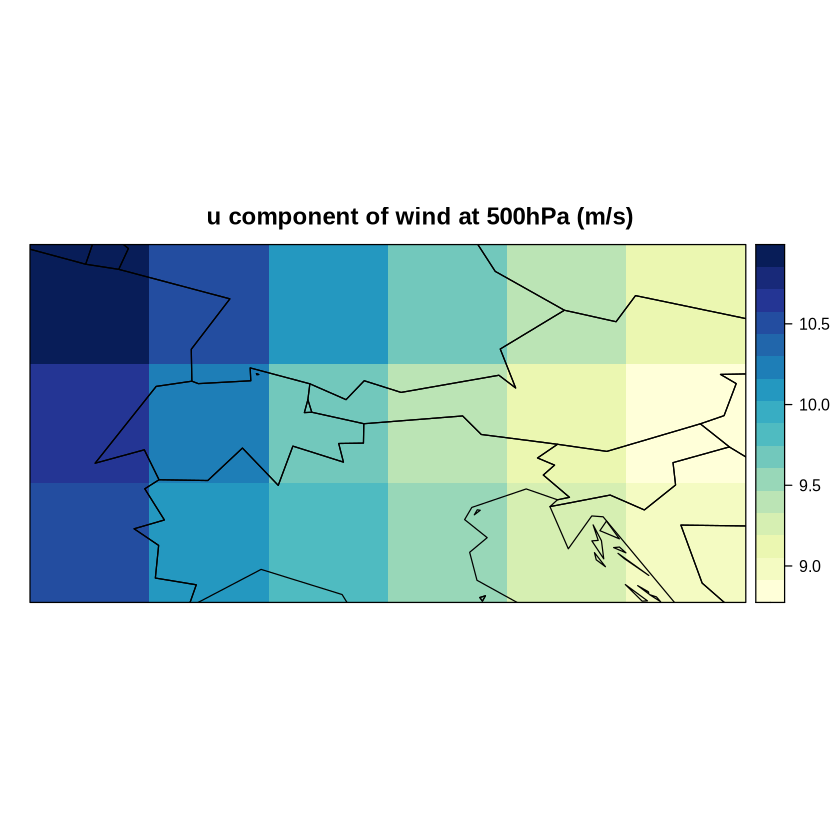

In [16]:
spatialPlot(climatology(hist), backdrop.theme = "countries", color.theme = "YlGnBu", main= "u component of wind at 500hPa (m/s)")

Note: In `script03_downscaling_GCM.ipynb` GCM data spanning 1990-2020 were dowscaled first. For that purposes, period 2006-2020 from the RCP was concatenated to the historical simulation (until 2005).

### Load future scenario data

Similarly, GCM data for the scenario periods can be loaded, indicating the dataset name and the desired period:

In [17]:
subset_rcp45 <- subset(df, activity == 'CMIP5'  & experiment == 'rcp45' & variable=='ua' & model== 'MPI-ESM-MR' & ensemble == 'r1i1p1')
dataset_rcp45 <- as.character(subset_rcp45$location)
dataset_rcp45
data <- loadGridData(dataset = dataset_rcp45, var = var, latLim = lats.big, lonLim = lons.big, year = years.rcp)

[1] "https://data.meteo.unican.es/thredds/dodsC/esgf/replica/temporal/CMIP5/output1/MPI-M/MPI-ESM-MR/rcp45/r1i1p1/day/atmos/day/v20120503/CMIP5_output1_MPI-M_MPI-ESM-MR_rcp45_r1i1p1_day_atmos_day_ua_v20120503.ncml"

[2026-02-21 20:42:11.08363] Opening dataset...

[2026-02-21 20:44:50.581698] The dataset was successfuly opened

[2026-02-21 20:44:50.586338] Defining geo-location parameters

[2026-02-21 20:44:50.613239] Defining time selection parameters

[2026-02-21 20:44:54.346585] Retrieving data subset ...

[2026-02-21 20:46:41.008863] Done



Next, perform  units conversion (if needed) and spatial interpolation to the reanalysis grid.

In [18]:
if(var== "zg@500" | var== "zg@850"){
	if(getGridUnits(data)=="m"){
		data <- gridArithmetics(data, 9.8, operator="*")
	}
}		
rcp <- interpGrid(data, new.coordinates= grid_rea, method="bilinear")
data <- NULL

[2026-02-21 20:46:41.217129] Performing bilinear interpolation... may take a while

[2026-02-21 20:46:54.890168] Done



We can check the temporal evolution of the predictor year-by-year for 1990-2100, over the domain (spatial average):

In [21]:
data <- bindGrid(hist, rcp,dimension = "time")
data_year <- aggregateGrid(data, aggr.y = list(FUN = "mean", na.rm = TRUE))


[2026-02-21 20:49:13.647675] Performing annual aggregation...

[2026-02-21 20:49:13.670061] Done.



pad applied on the interval: year



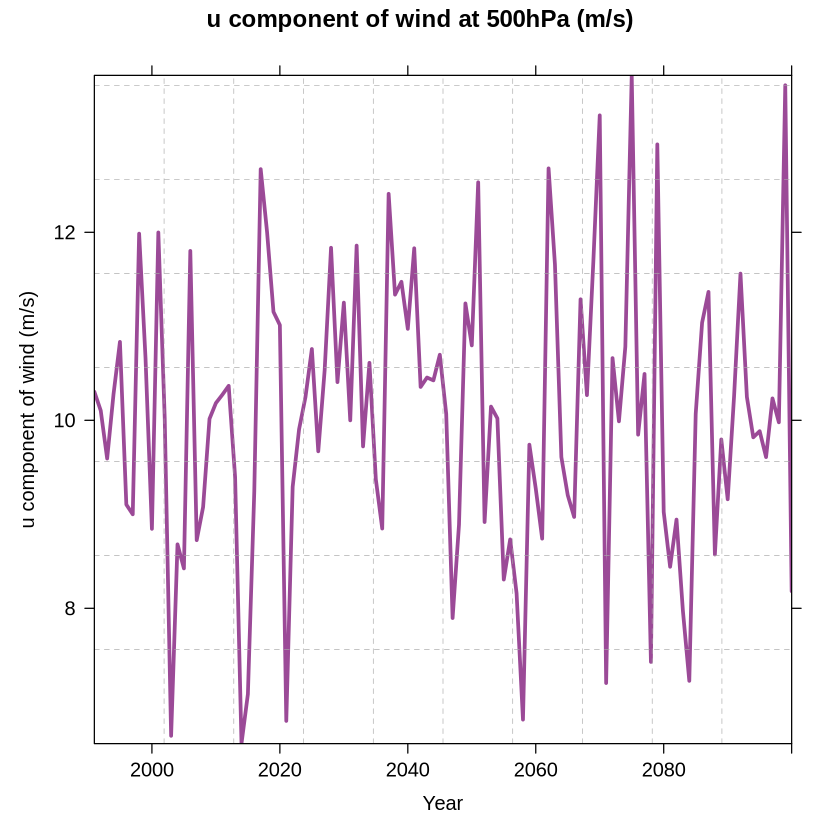

In [22]:
temporalPlot(data_year,
	cols="#9B4A97FF", 
	lwd = 3, 
	xyplot.custom = list(main = "u component of wind at 500hPa (m/s)", xlab = "Year",
	ylab= "u component of wind (m/s)",
	scales=list(x=list(cex=1), y=list(cex=1)), # size of ticks
	key = list( space = "out", points = list(pch= 26), text = list(c("",""), cex = 0.1))
	))